In [24]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def train_xgboost_multiple_params(
    labeled_csv: str,
    entropy_parquet: str,
    elbow_parquet: str,
    param_list: list,
    model_prefix: str = "xgb_model"
):    
    df_label = pd.read_csv(labeled_csv)
    df_entropy = pd.read_parquet(entropy_parquet, engine="pyarrow")
    df_elbow = pd.read_parquet(elbow_parquet, engine="pyarrow")

    df = df_label.merge(df_entropy, on="question_id", how="left")
    df = df.merge(df_elbow, on="question_id", how="left")

    drop_cols = [c for c in ["content", "probs"] if c in df.columns]
    df = df.drop(columns=drop_cols)

    X = df.drop(columns=["question_id", "ambiguous"])
    y = df["ambiguous"].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    for i, params in enumerate(param_list):
        print(f"\n=== Training with parameter set {i+1} ===")
        print(params)

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        evals_result = {}
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=500,
            evals=[(dtrain, "train"), (dtest, "test")],
            early_stopping_rounds=50,
            evals_result=evals_result,
            verbose_eval=True
        )

        y_pred_prob = bst.predict(dtest)
        y_pred = (y_pred_prob > 0.5).astype(int)

        print("Accuracy:", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))

        train_logloss = evals_result["train"]["logloss"]
        test_logloss = evals_result["test"]["logloss"]
        plt.figure(figsize=(8,5))
        plt.plot(train_logloss, label="Train logloss")
        plt.plot(test_logloss, label="Test logloss")
        plt.title(f"Logloss Curve - Param set {i+1}")
        plt.xlabel("Boosting round")
        plt.ylabel("Logloss")
        plt.legend()
        plt.show()

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix - Param set {i+1}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0,1],[0,1],"--", color="gray")
        plt.title(f"ROC Curve - Param set {i+1}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

        model_path = f"{model_prefix}_set{i+1}.json"
        bst.save_model(model_path)
        print(f"Model saved to {model_path}")



=== Training with parameter set 1 ===
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'max_depth': 3, 'eta': 0.05, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 5, 'gamma': 1.0, 'lambda': 1.0, 'alpha': 0.5, 'seed': 42}
[0]	train-logloss:0.68921	test-logloss:0.69075
[1]	train-logloss:0.68641	test-logloss:0.69122
[2]	train-logloss:0.68494	test-logloss:0.69220
[3]	train-logloss:0.68307	test-logloss:0.69374
[4]	train-logloss:0.68172	test-logloss:0.69333
[5]	train-logloss:0.67947	test-logloss:0.69370
[6]	train-logloss:0.67757	test-logloss:0.69493
[7]	train-logloss:0.67590	test-logloss:0.69560
[8]	train-logloss:0.67389	test-logloss:0.69648
[9]	train-logloss:0.67127	test-logloss:0.69706
[10]	train-logloss:0.66914	test-logloss:0.69765
[11]	train-logloss:0.66690	test-logloss:0.69835
[12]	train-logloss:0.66552	test-logloss:0.69847
[13]	train-logloss:0.66508	test-logloss:0.69800
[14]	train-logloss:0.66287	test-logloss:0.69975
[15]	train-logloss:0.66087	test-logloss:0.

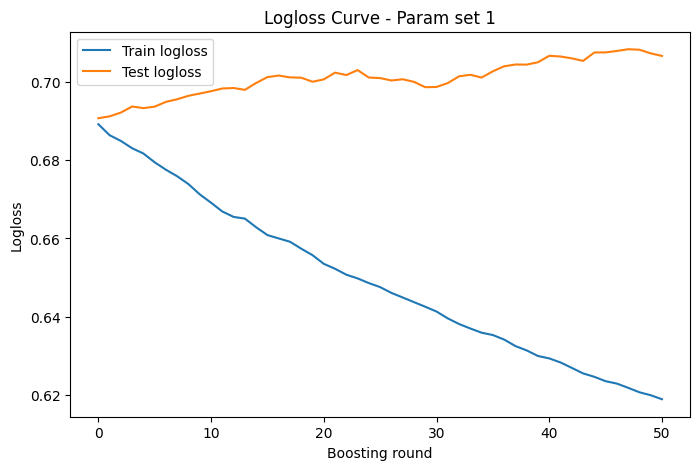

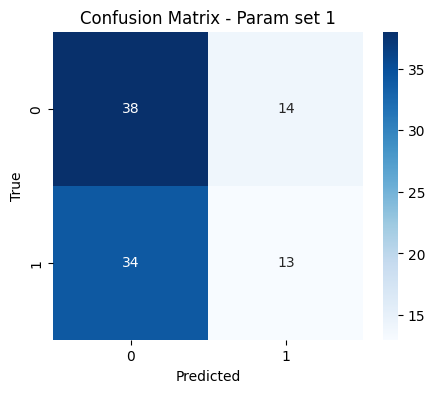

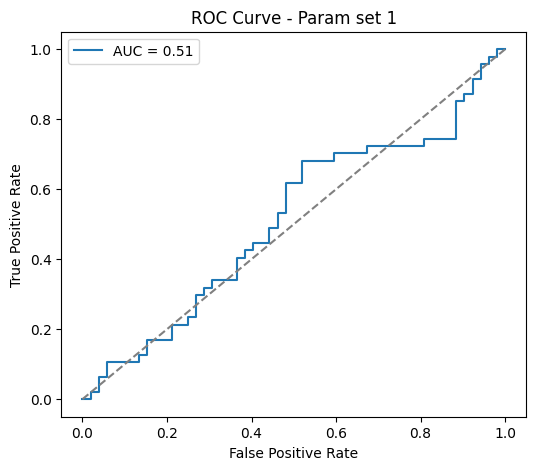

Model saved to xgb_model_set1.json

=== Training with parameter set 2 ===
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'max_depth': 5, 'eta': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'seed': 42}
[0]	train-logloss:0.67524	test-logloss:0.68775
[1]	train-logloss:0.66289	test-logloss:0.69414
[2]	train-logloss:0.65450	test-logloss:0.69027
[3]	train-logloss:0.64219	test-logloss:0.68772
[4]	train-logloss:0.63234	test-logloss:0.68623
[5]	train-logloss:0.62327	test-logloss:0.68379
[6]	train-logloss:0.61404	test-logloss:0.68376
[7]	train-logloss:0.60465	test-logloss:0.68475
[8]	train-logloss:0.59764	test-logloss:0.68622
[9]	train-logloss:0.59014	test-logloss:0.68711
[10]	train-logloss:0.58226	test-logloss:0.69057
[11]	train-logloss:0.57604	test-logloss:0.69032
[12]	train-logloss:0.56850	test-logloss:0.69088
[13]	train-logloss:0.56281	test-logloss:0.69185
[14]	train-logloss:0.56102	test-logloss:0.69207
[15]	train-logloss:0.55481	test-logloss:0.69632
[16]	train-logloss:0.54756

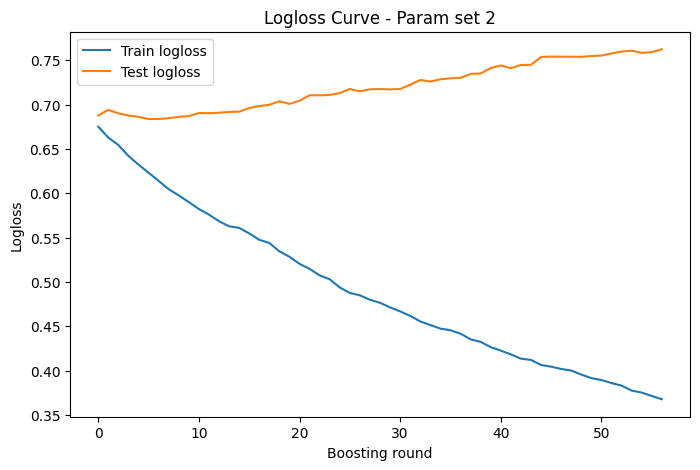

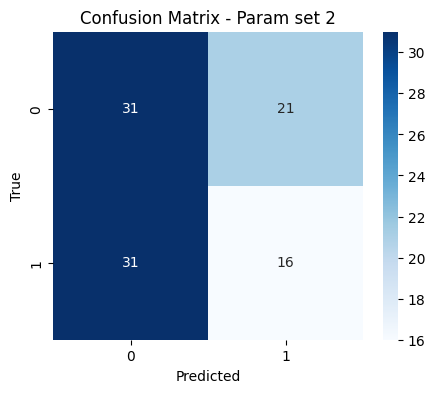

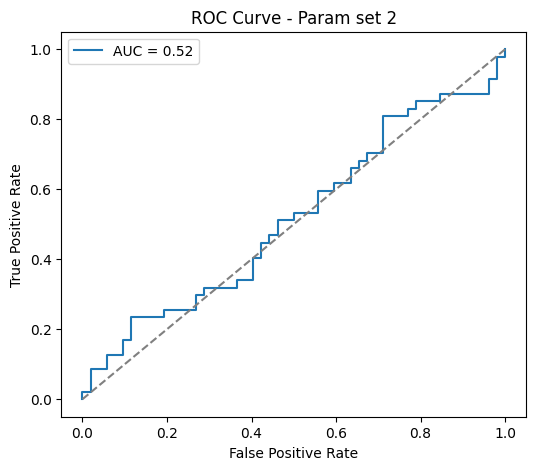

Model saved to xgb_model_set2.json

=== Training with parameter set 3 ===
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'max_depth': 7, 'eta': 0.03, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'seed': 42}
[0]	train-logloss:0.68698	test-logloss:0.69245
[1]	train-logloss:0.68243	test-logloss:0.69311
[2]	train-logloss:0.67786	test-logloss:0.69401
[3]	train-logloss:0.67352	test-logloss:0.69320
[4]	train-logloss:0.66828	test-logloss:0.69263
[5]	train-logloss:0.66477	test-logloss:0.69247
[6]	train-logloss:0.66087	test-logloss:0.69227
[7]	train-logloss:0.65628	test-logloss:0.69299
[8]	train-logloss:0.65281	test-logloss:0.69165
[9]	train-logloss:0.64885	test-logloss:0.69297
[10]	train-logloss:0.64545	test-logloss:0.69396
[11]	train-logloss:0.64165	test-logloss:0.69534
[12]	train-logloss:0.63879	test-logloss:0.69480
[13]	train-logloss:0.63541	test-logloss:0.69598
[14]	train-logloss:0.63255	test-logloss:0.69636
[15]	train-logloss:0.62809	test-logloss:0.69776
[1

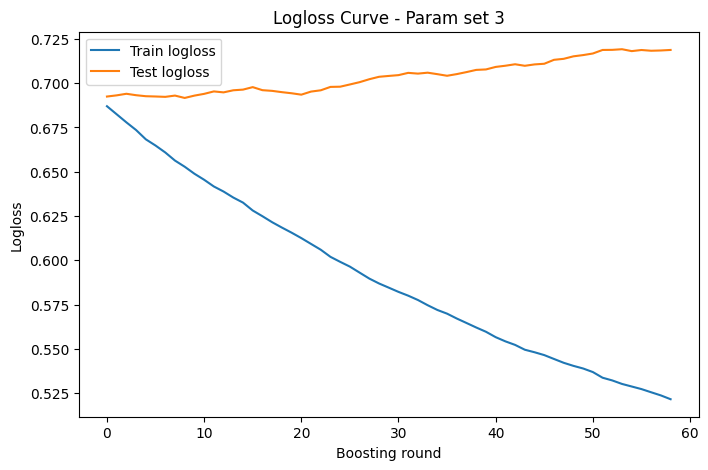

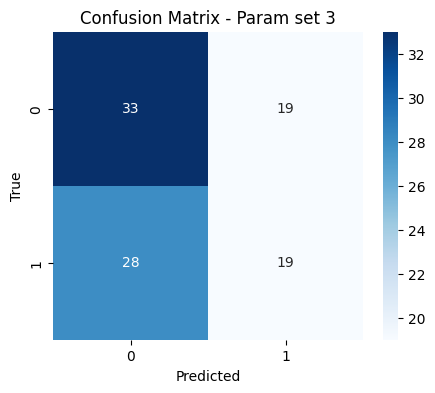

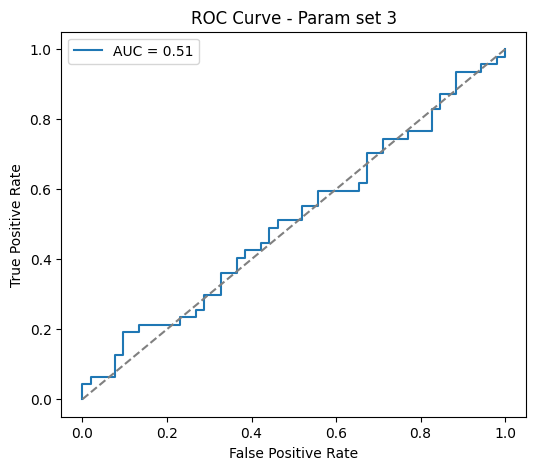

Model saved to xgb_model_set3.json

=== Training with parameter set 4 ===
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'max_depth': 4, 'eta': 0.05, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 10, 'gamma': 2.0, 'lambda': 2.0, 'alpha': 1.0, 'seed': 42}
[0]	train-logloss:0.69127	test-logloss:0.69193
[1]	train-logloss:0.69073	test-logloss:0.69211
[2]	train-logloss:0.69074	test-logloss:0.69212
[3]	train-logloss:0.68994	test-logloss:0.69222
[4]	train-logloss:0.68880	test-logloss:0.69379
[5]	train-logloss:0.68823	test-logloss:0.69350
[6]	train-logloss:0.68772	test-logloss:0.69323
[7]	train-logloss:0.68614	test-logloss:0.69335
[8]	train-logloss:0.68614	test-logloss:0.69335
[9]	train-logloss:0.68503	test-logloss:0.69428
[10]	train-logloss:0.68451	test-logloss:0.69443
[11]	train-logloss:0.68333	test-logloss:0.69518
[12]	train-logloss:0.68305	test-logloss:0.69455
[13]	train-logloss:0.68306	test-logloss:0.69458
[14]	train-logloss:0.68310	test-logloss:0.69467
[15]	t

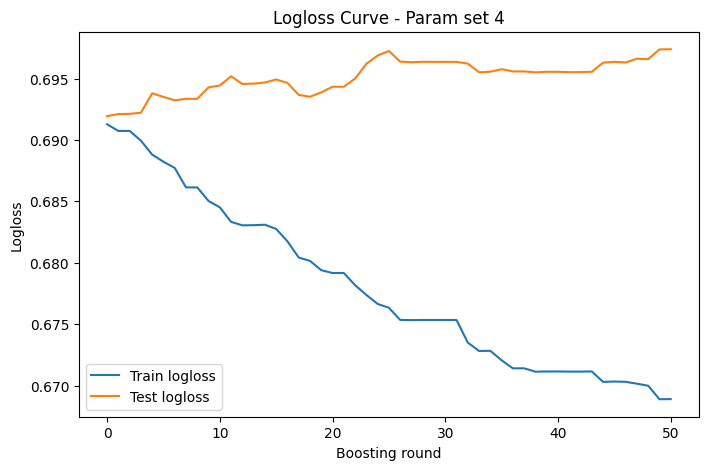

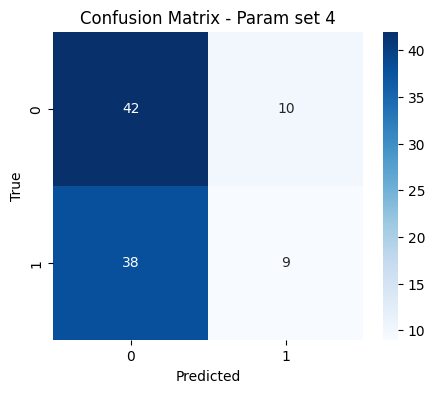

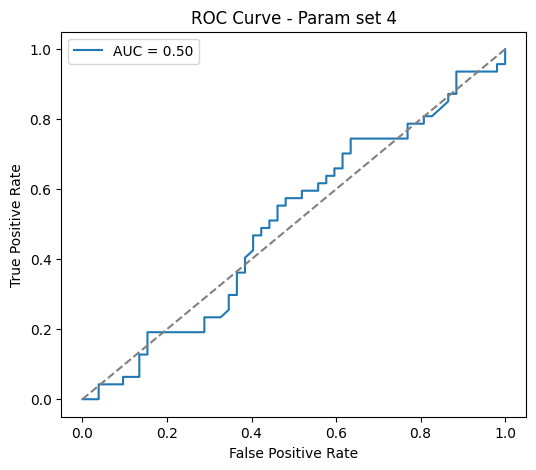

Model saved to xgb_model_set4.json

=== Training with parameter set 5 ===
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'max_depth': 3, 'eta': 0.2, 'subsample': 0.8, 'colsample_bytree': 0.8, 'seed': 42}
[0]	train-logloss:0.67292	test-logloss:0.68888
[1]	train-logloss:0.66200	test-logloss:0.69127
[2]	train-logloss:0.65410	test-logloss:0.68658
[3]	train-logloss:0.64673	test-logloss:0.69612
[4]	train-logloss:0.63945	test-logloss:0.69839
[5]	train-logloss:0.62845	test-logloss:0.70037
[6]	train-logloss:0.61576	test-logloss:0.70471
[7]	train-logloss:0.61088	test-logloss:0.71235
[8]	train-logloss:0.60533	test-logloss:0.71664
[9]	train-logloss:0.59999	test-logloss:0.71871
[10]	train-logloss:0.59674	test-logloss:0.71937
[11]	train-logloss:0.58679	test-logloss:0.72497
[12]	train-logloss:0.58015	test-logloss:0.72442
[13]	train-logloss:0.57563	test-logloss:0.72386
[14]	train-logloss:0.57243	test-logloss:0.72437
[15]	train-logloss:0.56439	test-logloss:0.73159
[16]	train-logloss:0.55901

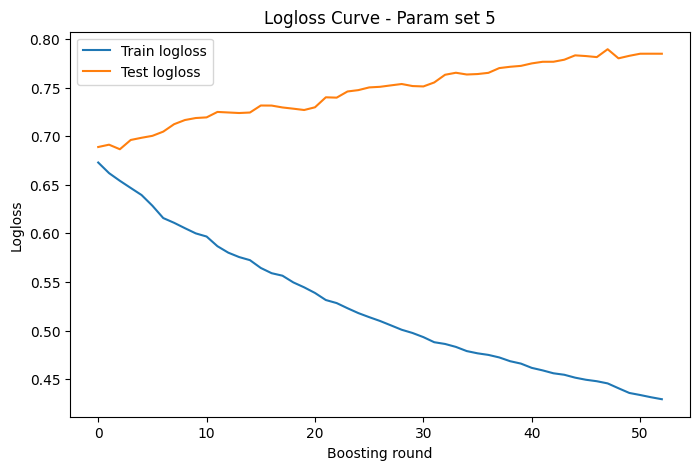

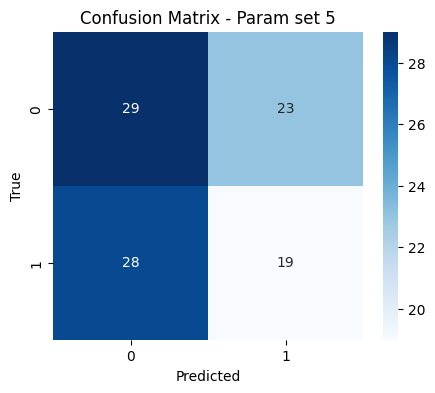

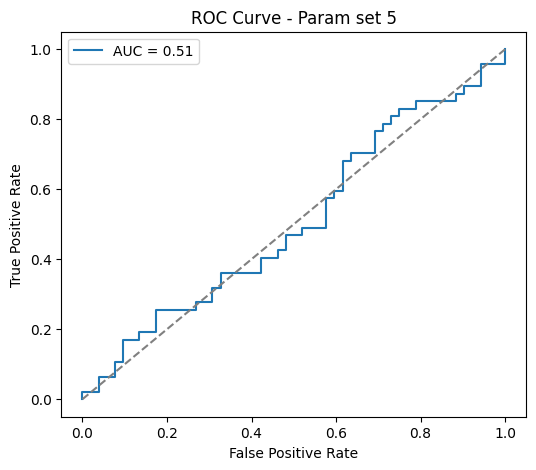

Model saved to xgb_model_set5.json


In [26]:
param_sets = [
    {"objective":"binary:logistic","eval_metric":"logloss","max_depth":3,"eta":0.05,"subsample":0.7,"colsample_bytree":0.7,"min_child_weight":5,"gamma":1.0,"lambda":1.0,"alpha":0.5,"seed":42},
    {"objective":"binary:logistic","eval_metric":"logloss","max_depth":5,"eta":0.1,"subsample":0.8,"colsample_bytree":0.8,"seed":42},
    {"objective":"binary:logistic","eval_metric":"logloss","max_depth":7,"eta":0.03,"subsample":0.9,"colsample_bytree":0.9,"min_child_weight":3,"seed":42},
    {"objective":"binary:logistic","eval_metric":"logloss","max_depth":4,"eta":0.05,"subsample":0.6,"colsample_bytree":0.6,"min_child_weight":10,"gamma":2.0,"lambda":2.0,"alpha":1.0,"seed":42},
    {"objective":"binary:logistic","eval_metric":"logloss","max_depth":3,"eta":0.2,"subsample":0.8,"colsample_bytree":0.8,"seed":42}
]

train_xgboost_multiple_params(
    "../data/messages_202512292119_labeled.csv",
    "../data/messages_202512292119_chunks_entropy_results.parquet",
    "../data/messages_202512292119_chunks_elbow_steepness_results.parquet",
    param_sets
)
